# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from warnings import filterwarnings

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer  
from scipy.special import inv_boxcox

filterwarnings('ignore')
%matplotlib inline

# Read the training data

In [2]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(10656, 10)


,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
train_df.describe()

,ID,bath,balcony,price
count,10656.000000,10591.000000,10152.000000,10656.000000
mean,5327.500000,2.690586,1.581757,112.214256
std,3076.266568,1.352403,0.821357,142.231967
min,0.000000,1.000000,0.000000,8.000000
25%,2663.750000,2.000000,1.000000,50.000000
50%,5327.500000,2.000000,2.000000,72.000000
75%,7991.250000,3.000000,2.000000,120.000000
max,10655.000000,40.000000,3.000000,2700.000000


In [4]:
train_df.describe(include='object')

,area_type,availability,location,size,society,total_sqft
count,10656,10656,10655,10642,6228,10656
unique,4,79,1197,30,2364,1923
top,Super built-up Area,Ready To Move,Whitefield,2 BHK,GrrvaGr,1200
freq,7009,8468,433,4146,70,667


# Data Cleaning

In [5]:
train_df['availability'].unique()

array(['19-Dec', 'Ready To Move', '18-May', '18-Feb', '18-Nov', '20-Dec',
       '17-Oct', '21-Dec', '19-Sep', '20-Sep', '18-Mar', '20-Feb',
       '18-Apr', '20-Aug', '18-Oct', '19-Mar', '17-Sep', '18-Dec',
       '17-Aug', '19-Apr', '18-Jun', '22-Dec', '22-Jan', '18-Aug',
       '19-Jan', '17-Jul', '18-Jul', '21-Jun', '20-May', '19-Aug',
       '18-Sep', '17-May', '17-Jun', '21-May', '18-Jan', '20-Mar',
       '17-Dec', '16-Mar', '19-Jun', '22-Jun', '19-Jul', '21-Feb',
       'Immediate Possession', '19-May', '17-Nov', '20-Oct', '20-Jun',
       '19-Feb', '21-Oct', '21-Jan', '17-Mar', '17-Apr', '22-May',
       '19-Oct', '21-Jul', '21-Nov', '21-Mar', '16-Dec', '22-Mar',
       '20-Jan', '21-Sep', '21-Aug', '14-Nov', '19-Nov', '15-Nov',
       '16-Jul', '15-Jun', '17-Feb', '20-Nov', '20-Jul', '16-Sep',
       '15-Oct', '15-Dec', '16-Oct', '22-Nov', '15-Aug', '17-Jan',
       '16-Nov', '20-Apr'], dtype=object)

In [6]:
def find_alpha(text):
    result = re.findall("[A-Za-z]",text)
    return ''.join(result)

train_df['availability'] = train_df['availability'].apply(lambda x: find_alpha(x))
train_df['size'] = train_df['size'].str.replace('Bedroom','BHK')
train_df['size'] = train_df['size'].str.replace('1 RK','0')

train_df['units'] = train_df['total_sqft'].apply(lambda x: find_alpha(x))
train_df.loc[train_df['units']=='','units']='sqft'
train_df['units'].unique()

array(['sqft', 'SqMeter', 'Perch', 'SqYards', 'Acres', 'Cents', 'Guntha',
       'Grounds'], dtype=object)

In [7]:
train_df['availability'].unique()

array(['Dec', 'ReadyToMove', 'May', 'Feb', 'Nov', 'Oct', 'Sep', 'Mar',
       'Apr', 'Aug', 'Jun', 'Jan', 'Jul', 'ImmediatePossession'],
      dtype=object)

In [8]:
train_df['availability'].replace(['Dec', 'May', 'Feb', 'Nov', 'Oct', 'Sep', 'Mar', 'Apr', 'Aug', 'Jun', 'Jan', 'Jul'], 
                                 'UnderConstruction', inplace=True)
train_df['availability'].unique()

array(['UnderConstruction', 'ReadyToMove', 'ImmediatePossession'],
      dtype=object)

<AxesSubplot:>

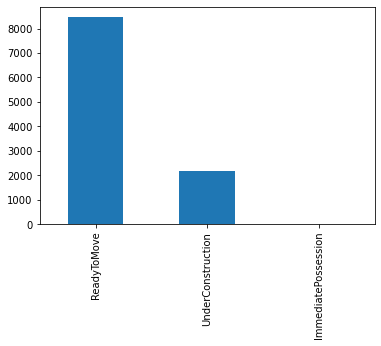

In [9]:
train_df['availability'].value_counts().plot(kind='bar')

In [10]:

unit_lst = ['Sq. Meter', 'Perch', 'Sq. Yards', 'Acres', 'Cents', 'Guntha','Grounds']
# remove the unit from the sq ft column
for unit in unit_lst:
    train_df['total_sqft'] = train_df['total_sqft'].str.replace(unit,'')

# verify there is no unit in sq ft column after removing it
sr = train_df['total_sqft'].apply(lambda x: find_alpha(x))
# if there are 2 sqft values seperated by '-', take the average of them
train_df['total_sqft'] = train_df['total_sqft'].str.split('-').apply(lambda x: (float(x[0])+float(x[-1]))/2)
sr.unique()

array([''], dtype=object)

In [11]:
unit_lst = train_df['units'].unique().tolist()
unit_lst

['sqft', 'SqMeter', 'Perch', 'SqYards', 'Acres', 'Cents', 'Guntha', 'Grounds']

In [12]:
train_df[train_df['units']=='SqMeter'].head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price,units
410,410,Super built-up Area,ReadyToMove,Kengeri,1 BHK,NaN,34.46,1.0,0.0,18.5,SqMeter
775,775,Built-up Area,ReadyToMove,Basavanagara,1 BHK,NaN,1000.00,2.0,1.0,93.0,SqMeter
1400,1400,Super built-up Area,ReadyToMove,Chamrajpet,9 BHK,NaN,716.00,9.0,1.0,296.0,SqMeter
1712,1712,Plot Area,ReadyToMove,Singena Agrahara,3 BHK,CoiewSy,1500.00,3.0,1.0,95.0,SqMeter
1743,1743,Super built-up Area,UnderConstruction,Hosa Road,3 BHK,Sosisic,142.61,3.0,1.0,115.0,SqMeter


In [13]:
# convert all into sq m
def cal_sqft(x,unit_lst):
    
    mul_dt = dict(zip(unit_lst, [1, 10.76391042, 272.25, 9, 43560, 435.56, 1089, 2400]))
    return round(x['total_sqft'] * mul_dt[x['units']], 2)
unit_lst = train_df['units'].unique().tolist()
train_df['total_sqft'] = train_df[['total_sqft','units']].apply(lambda x: cal_sqft(x,unit_lst), axis=1)
train_df[train_df['units'] == 'SqMeter'].head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price,units
410,410,Super built-up Area,ReadyToMove,Kengeri,1 BHK,NaN,370.92,1.0,0.0,18.5,SqMeter
775,775,Built-up Area,ReadyToMove,Basavanagara,1 BHK,NaN,10763.91,2.0,1.0,93.0,SqMeter
1400,1400,Super built-up Area,ReadyToMove,Chamrajpet,9 BHK,NaN,7706.96,9.0,1.0,296.0,SqMeter
1712,1712,Plot Area,ReadyToMove,Singena Agrahara,3 BHK,CoiewSy,16145.87,3.0,1.0,95.0,SqMeter
1743,1743,Super built-up Area,UnderConstruction,Hosa Road,3 BHK,Sosisic,1535.04,3.0,1.0,115.0,SqMeter


In [14]:
train_df = train_df.drop(columns=['units'])
train_df.head(1)

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,Super built-up Area,UnderConstruction,Electronic City Phase II,2 BHK,Coomee,1056.0,2.0,1.0,39.07


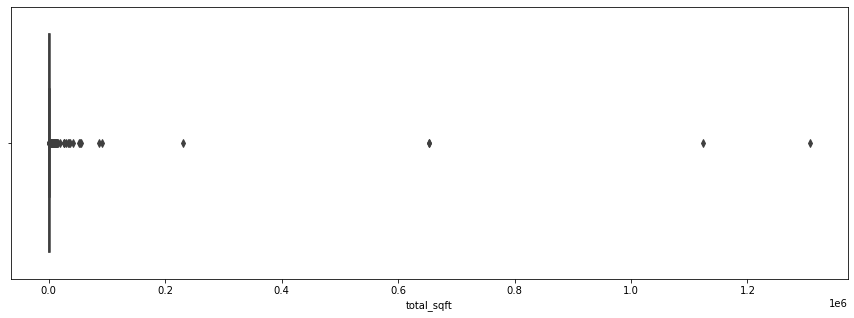

In [15]:
plt.figure(figsize=(15,5))
sns.boxplot(train_df['total_sqft'])
plt.show()

In [16]:
train_df.groupby('area_type')['total_sqft'].agg(['mean','median'])

,mean,median
area_type,,
Built-up Area,2225.208282,1300.0
Carpet Area,1228.640725,1103.0
Plot Area,3768.283731,1200.0
Super built-up Area,1486.113523,1280.0


# Read Avg Rent data

In [17]:
rent_df = pd.read_csv('avg_rent.csv')
rent_df.head()

,location,avg_2bhk_rent
0,Krishnarajapura,11954
1,Sarjapur,45000
2,Whitefield Hope Farm Junction,26370
3,Devanahalli,17302
4,Whitefield,14981


In [18]:
train_df = train_df.merge(rent_df, on='location',how='left')
train_df.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price,avg_2bhk_rent
0,0,Super built-up Area,UnderConstruction,Electronic City Phase II,2 BHK,Coomee,1056.0,2.0,1.0,39.07,11500.0
1,1,Plot Area,ReadyToMove,Chikka Tirupathi,4 BHK,Theanmp,2600.0,5.0,3.0,120.00,NaN
2,2,Built-up Area,ReadyToMove,Uttarahalli,3 BHK,NaN,1440.0,2.0,3.0,62.00,19750.0
3,3,Super built-up Area,ReadyToMove,Lingadheeranahalli,3 BHK,Soiewre,1521.0,3.0,1.0,95.00,NaN
4,4,Super built-up Area,ReadyToMove,Kothanur,2 BHK,NaN,1200.0,2.0,1.0,51.00,16375.0


# Read Distance from city centre data

In [19]:
dist_df = pd.read_csv('dist_from_city_centre.csv')
dist_df.head()

,location,dist_from_city
0,Whitefield,17.3
1,Sarjapur Road,17.2
2,Electronic City,18.1
3,Kanakpura Road,26.5
4,Thanisandra,11.5


In [20]:
train_df = train_df.merge(dist_df, on='location', how='left')
train_df.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price,avg_2bhk_rent,dist_from_city
0,0,Super built-up Area,UnderConstruction,Electronic City Phase II,2 BHK,Coomee,1056.0,2.0,1.0,39.07,11500.0,19.3
1,1,Plot Area,ReadyToMove,Chikka Tirupathi,4 BHK,Theanmp,2600.0,5.0,3.0,120.00,NaN,34.6
2,2,Built-up Area,ReadyToMove,Uttarahalli,3 BHK,NaN,1440.0,2.0,3.0,62.00,19750.0,12.9
3,3,Super built-up Area,ReadyToMove,Lingadheeranahalli,3 BHK,Soiewre,1521.0,3.0,1.0,95.00,NaN,21.4
4,4,Super built-up Area,ReadyToMove,Kothanur,2 BHK,NaN,1200.0,2.0,1.0,51.00,16375.0,11.8


# Handling Missing Values

In [21]:
sr = train_df.isna().sum()/len(train_df)
sr[sr>0]

location          0.000094
size              0.001314
society           0.415541
bath              0.006100
balcony           0.047297
avg_2bhk_rent     0.656062
dist_from_city    0.096284
dtype: float64

In [22]:
# we are dropping society as it has more number of missing values
# we are dropping ID as it is not useful for model building
train_df = train_df.drop(columns=['society','ID'])
train_df.head(1)

,area_type,availability,location,size,total_sqft,bath,balcony,price,avg_2bhk_rent,dist_from_city
0,Super built-up Area,UnderConstruction,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,11500.0,19.3


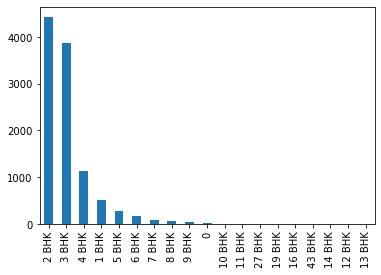

In [23]:
train_df['size'].value_counts().plot(kind='bar')
plt.show()

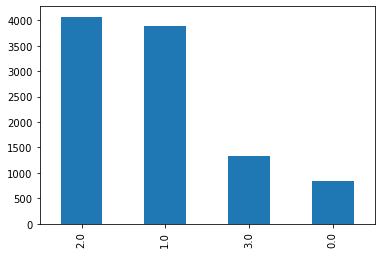

In [24]:
train_df['balcony'].value_counts().plot(kind='bar')
plt.show()

In [25]:
train_df['location'].value_counts(normalize=True)

Whitefield                0.040638
Sarjapur  Road            0.028437
Electronic City           0.021962
Kanakpura Road            0.020366
Thanisandra               0.016706
                            ...   
Sahyadri Layout           0.000094
Laxminarayana Layout      0.000094
Kanakadasa Layout         0.000094
Indira Nagar 3rd Stage    0.000094
Panathur Road,            0.000094
Name: location, Length: 1197, dtype: float64

In [26]:
def find_alpha(text):
    result = re.findall("[A-Za-z]", text)
    return ''.join(result)

In [27]:
# filling missing values
train_df['size'] = train_df['size'].fillna(train_df['size'].mode()[0])

# data cleaning
train_df['size'] = train_df['size'].str.extract('(\d+)')
train_df['size'] = train_df['size'].astype(int)

# filling missing values
train_df['balcony'] = train_df['balcony'].fillna(train_df['balcony'].mode()[0])
train_df['location'] = train_df['location'].fillna(train_df['location'].mode()[0])
train_df['bath'] = train_df['bath'].fillna(train_df['bath'].mode()[0])

# data formating
train_df['bath'] = train_df['bath'].astype(int)
train_df['balcony'] = train_df['balcony'].astype(int)

train_df.isna().sum()/len(train_df)

area_type         0.000000
availability      0.000000
location          0.000000
size              0.000000
total_sqft        0.000000
bath              0.000000
balcony           0.000000
price             0.000000
avg_2bhk_rent     0.656062
dist_from_city    0.096284
dtype: float64

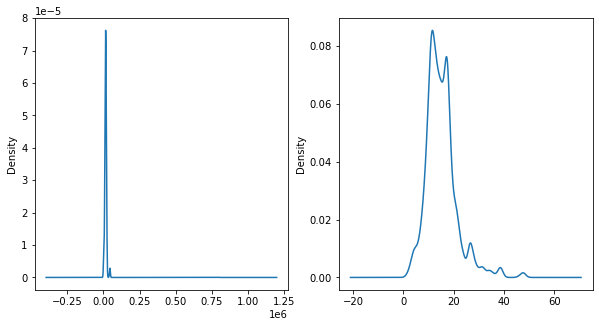

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
train_df['avg_2bhk_rent'].plot(kind='kde')
plt.subplot(1,2,2)
train_df['dist_from_city'].plot(kind='kde')
plt.show()

In [29]:
impu = KNNImputer() 
impu_df = train_df[['avg_2bhk_rent','dist_from_city']].copy()
impu_arr = impu.fit_transform(impu_df)
impu_df = pd.DataFrame(impu_arr, columns=impu_df.columns) 
train_df['avg_2bhk_rent'] = train_df['avg_2bhk_rent'].fillna(round(impu_df['avg_2bhk_rent']))
train_df['dist_from_city'] = train_df['dist_from_city'].fillna(round(impu_df['dist_from_city'],1))
sr = train_df.isna().sum()/len(train_df)
sr[sr>0]

Series([], dtype: float64)

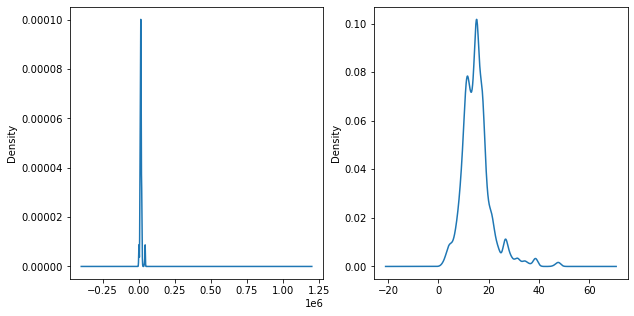

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
train_df['avg_2bhk_rent'].plot(kind='kde')
plt.subplot(1,2,2)
train_df['dist_from_city'].plot(kind='kde')
plt.show()

In [31]:
train_df = train_df.drop(columns=['location'])
train_df.head()

,area_type,availability,size,total_sqft,bath,balcony,price,avg_2bhk_rent,dist_from_city
0,Super built-up Area,UnderConstruction,2,1056.0,2,1,39.07,11500.0,19.3
1,Plot Area,ReadyToMove,4,2600.0,5,3,120.00,7500.0,34.6
2,Built-up Area,ReadyToMove,3,1440.0,2,3,62.00,19750.0,12.9
3,Super built-up Area,ReadyToMove,3,1521.0,3,1,95.00,14300.0,21.4
4,Super built-up Area,ReadyToMove,2,1200.0,2,1,51.00,16375.0,11.8


# Encoding

In [32]:
train_df = pd.get_dummies(train_df)
train_df.head()

,size,total_sqft,bath,balcony,price,avg_2bhk_rent,dist_from_city,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_ImmediatePossession,availability_ReadyToMove,availability_UnderConstruction
0,2,1056.0,2,1,39.07,11500.0,19.3,0,0,0,1,0,0,1
1,4,2600.0,5,3,120.00,7500.0,34.6,0,0,1,0,0,1,0
2,3,1440.0,2,3,62.00,19750.0,12.9,1,0,0,0,0,1,0
3,3,1521.0,3,1,95.00,14300.0,21.4,0,0,0,1,0,1,0
4,2,1200.0,2,1,51.00,16375.0,11.8,0,0,0,1,0,1,0


# Handling Outliers

In [33]:
train_df.skew().sort_values(ascending=False)

total_sqft                          56.196758
avg_2bhk_rent                       38.282387
availability_ImmediatePossession    27.538295
area_type_Carpet  Area              12.307881
price                                6.751465
size                                 5.255641
bath                                 4.580424
area_type_Plot  Area                 1.907521
area_type_Built-up  Area             1.658726
dist_from_city                       1.588947
availability_UnderConstruction       1.469176
balcony                             -0.065702
area_type_Super built-up  Area      -0.665063
availability_ReadyToMove            -1.459173
dtype: float64

In [34]:
out_train_df = train_df.copy()
out_train_df = out_train_df.drop(columns=['availability_ImmediatePossession','area_type_Carpet  Area'])
for col in ['size', 'bath', 'total_sqft','avg_2bhk_rent','dist_from_city']:
    q1 = train_df[col].quantile(0.25)
    q3 = train_df[col].quantile(0.75)
    iqr = q3 - q1
    lb = round(q1 - 1.5*iqr)
    ub = round(q3 + 1.5*iqr)
    out_train_df.loc[out_train_df[col]<lb, col] = lb
    out_train_df.loc[out_train_df[col]>ub, col] = ub
    
out_train_df.skew().sort_values(ascending=False)

price                             6.751465
area_type_Plot  Area              1.907521
area_type_Built-up  Area          1.658726
availability_UnderConstruction    1.469176
total_sqft                        0.762481
bath                              0.473921
dist_from_city                    0.380470
size                              0.132901
avg_2bhk_rent                     0.092203
balcony                          -0.065702
area_type_Super built-up  Area   -0.665063
availability_ReadyToMove         -1.459173
dtype: float64

In [35]:
# Percentage of Outliers in the target variable
q1 = train_df['price'].quantile(0.25)
q3 = train_df['price'].quantile(0.75)
iqr = q3 - q1
lb = round(q1 - 1.5*iqr)
ub = round(q3 + 1.5*iqr)
'{:.2%}'.format(train_df[(train_df['price']<lb)|(train_df['price']>ub)].shape[0]/train_df.shape[0])

'9.68%'

# Train Test Split

In [36]:
X = out_train_df.drop(columns=['price'])
y = out_train_df['price']
xtrain,xvalid,ytrain,yvalid = train_test_split(X, y, test_size=0.2, random_state=0)
xtrain.shape,xvalid.shape,ytrain.shape,yvalid.shape

((8524, 11), (2132, 11), (8524,), (2132,))

In [37]:
X.head()

,size,total_sqft,bath,balcony,avg_2bhk_rent,dist_from_city,area_type_Built-up Area,area_type_Plot Area,area_type_Super built-up Area,availability_ReadyToMove,availability_UnderConstruction
0,2,1056.0,2,1,11500.0,19.3,0,0,1,0,1
1,4,2550.0,4,3,7500.0,26.0,0,1,0,1,0
2,3,1440.0,2,3,19750.0,12.9,1,0,0,1,0
3,3,1521.0,3,1,14300.0,21.4,0,0,1,1,0
4,2,1200.0,2,1,16375.0,11.8,0,0,1,1,0


# Build the model - 1

In [38]:
import statsmodels.api as sm

Xc = sm.add_constant(X)
model = sm.OLS(y, Xc)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     654.0
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:21:36   Log-Likelihood:                -65195.
No. Observations:               10656   AIC:                         1.304e+05
Df Residuals:                   10644   BIC:                         1.305e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -172.4761     33.227     -5.191      0.000    -237.606    -107.346
size                              -5.1321      2.654     -1.934      0.053     -10.334       0.069
total_sqft                         0.1364      0.003     47.562      0.000       0.131       0.142
bath                              14.6525      2.601      5.634      0.000       9.555      19.750
balcony                           -1.8878      1.440     -1.311      0.190      -4.710       0.935
avg_2bhk_rent                  -6.152e-05      0.000     -0.265      0.791      -0.001       0.000
dist_from_city                    -3.4293      0.224    -15.322      0.000      -3.868      -2.991
area_type_Built-up  Area         -19.1395     13.497     -1.418      0.156     -45.596       7.317
area_type_Plot  Area              66.1446     13.594      4.866      0.000      39.497      92.792
area_type_Super built-up  Area   -20.7591     13.322     -1.558      0.119     -46.873       5.355
availability_ReadyToMove         126.4627     29.817      4.241      0.000      68.015     184.910
availability_UnderConstruction   134.5715     29.904      4.500      0.000      75.954     193.189
==============================================================================
Omnibus:                    15501.279   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6856682.354
Skew:                           8.730   Prob(JB):                         0.00
Kurtosis:                     126.037   Cond. No.                     7.91e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
np.sqrt(np.sum(model.resid**2)/len(y))

109.86371824804141

In [40]:
model.resid.skew()

8.731458226090114

In [41]:
model.params.sort_values()

const                            -172.476055
area_type_Super built-up  Area    -20.759111
area_type_Built-up  Area          -19.139500
size                               -5.132149
dist_from_city                     -3.429297
balcony                            -1.887780
avg_2bhk_rent                      -0.000062
total_sqft                          0.136403
bath                               14.652537
area_type_Plot  Area               66.144583
availability_ReadyToMove          126.462699
availability_UnderConstruction    134.571527
dtype: float64

# Transform the output variable

In [42]:
from scipy import stats
y_trans,param = pd.Series(stats.boxcox(y)[0]),stats.boxcox(y)[1]
y_trans.skew(), param

(-0.02571003587462261, -0.32479328235953303)

In [43]:
pv = model.pvalues.round(2)
pv_columns = pv[pv>0.05].index.tolist()
pv_columns

['balcony',
 'avg_2bhk_rent',
 'area_type_Built-up  Area',
 'area_type_Super built-up  Area']

# Build the model - 2

In [44]:
# drop these columns because their p value is > .05
X = X.drop(columns=pv_columns)
Xc = sm.add_constant(X)
model = sm.OLS(y_trans, Xc)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     3929.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:21:36   Log-Likelihood:                 10858.
No. Observations:               10656   AIC:                        -2.170e+04
Df Residuals:                   10648   BIC:                        -2.164e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              1.8181      0.024     75.648      0.000       1.771       1.865
size                               0.0193      0.002      9.171      0.000       0.015       0.023
total_sqft                         0.0002   2.27e-06     73.477      0.000       0.000       0.000
bath                               0.0358      0.002     17.438      0.000       0.032       0.040
dist_from_city                    -0.0061      0.000    -34.654      0.000      -0.006      -0.006
area_type_Plot  Area               0.0864      0.003     32.434      0.000       0.081       0.092
availability_ReadyToMove           0.2012      0.024      8.499      0.000       0.155       0.248
availability_UnderConstruction     0.1959      0.024      8.258      0.000       0.149       0.242
==============================================================================
Omnibus:                      728.882   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2745.674
Skew:                          -0.260   Prob(JB):                         0.00
Kurtosis:                       5.432   Cond. No.                     7.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
ypred = model.predict(Xc)
inv_ypred = inv_boxcox(ypred, param)
inv_ytrans = inv_boxcox(y_trans, param)
inv_rmse = np.sqrt(np.sum((inv_ypred-inv_ytrans)**2)/len(y))
inv_rmse

102.73648933939134

# Remove Multicollinearity

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
for col_idx,col in enumerate(X):
    print(col,'-',
          round(variance_inflation_factor(exog=X.values, exog_idx=col_idx),2))

size - 47.4
total_sqft - 16.48
bath - 41.69
dist_from_city - 10.37
area_type_Plot  Area - 1.52
availability_ReadyToMove - 19.46
availability_UnderConstruction - 6.0


In [47]:
X = X.drop(columns='size')
for col_idx,col in enumerate(X):
    print(col,'-',
          round(variance_inflation_factor(exog=X.values, exog_idx=col_idx),2))

total_sqft - 15.32
bath - 21.64
dist_from_city - 10.37
area_type_Plot  Area - 1.47
availability_ReadyToMove - 18.24
availability_UnderConstruction - 5.74


In [48]:
X = X.drop(columns='availability_ReadyToMove')
for col_idx,col in enumerate(X):
    print(col,'-',
          round(variance_inflation_factor(exog=X.values, exog_idx=col_idx),2))

total_sqft - 14.7
bath - 18.37
dist_from_city - 5.19
area_type_Plot  Area - 1.45
availability_UnderConstruction - 1.29


In [49]:
X = X.drop(columns='bath')
for col_idx,col in enumerate(X):
    print(col,'-',
          round(variance_inflation_factor(exog=X.values, exog_idx=col_idx),2))

total_sqft - 4.37
dist_from_city - 4.52
area_type_Plot  Area - 1.2
availability_UnderConstruction - 1.29


We removed the multicollinearity

# Build the model - 3

In [50]:
Xc = sm.add_constant(X)
model = sm.OLS(y_trans, Xc)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     5815.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:21:37   Log-Likelihood:                 10229.
No. Observations:               10656   AIC:                        -2.045e+04
Df Residuals:                   10651   BIC:                        -2.041e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              2.0823      0.004    514.089      0.000       2.074       2.090
total_sqft                         0.0002   1.71e-06    129.073      0.000       0.000       0.000
dist_from_city                    -0.0064      0.000    -34.250      0.000      -0.007      -0.006
area_type_Plot  Area               0.1256      0.003     50.234      0.000       0.121       0.130
availability_UnderConstruction    -0.0076      0.002     -3.355      0.001      -0.012      -0.003
==============================================================================
Omnibus:                      986.490   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3850.401
Skew:                          -0.407   Prob(JB):                         0.00
Kurtosis:                       5.830   Cond. No.                     6.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
round(model.params,2)

const                             2.08
total_sqft                        0.00
dist_from_city                   -0.01
area_type_Plot  Area              0.13
availability_UnderConstruction   -0.01
dtype: float64

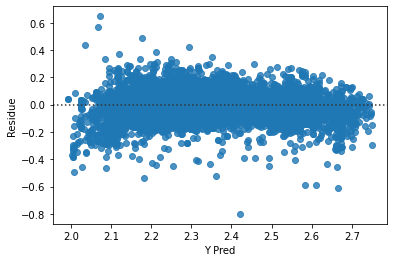

In [52]:
sns.residplot(model.predict(), model.resid)
plt.xlabel('Y Pred')
plt.ylabel('Residue')
plt.show()

The model is homescedasticity

In [53]:
from statsmodels.stats.diagnostic import linear_rainbow

_,p = linear_rainbow(res=model, frac=0.5)
p

0.39792200929774557

The model is linear

In [54]:
model.resid.skew()

-0.40691450860278205

* The normality assumption is satisfied
* No autocorrelation exist

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y_trans, test_size=0.2, random_state=0)
print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)

lr_mod = LinearRegression()
lr_mod.fit(xtrain, ytrain)

print('Test R2 score: {:.2%}\n'.format(lr_mod.score(xvalid, yvalid)))
print('Coefficients:')
for col,coef in zip(xtrain.columns, lr_mod.coef_):
    print(col,'-',round(coef,2))
    
print('B0 - {:.2f}'.format(lr_mod.intercept_))
ypred = lr_mod.predict(xvalid)
print("\nPredicted Values:\n{}".format([round(pred,2) for pred in ypred[:5]]))
print("\n Actual Values:\n{}".format(yvalid[:5]))


r2 = r2_score(yvalid, ypred)
print('\nTest R-square - {:.2%}'.format(r2))
ypred_train = lr_mod.predict(xtrain)
r2_train = r2_score(ytrain, ypred_train)
print('Train R-square - {:.2%}'.format(r2_train))
print("R2 Train - R2 Test = {:.2%}".format(r2_train - r2))

def get_rmse(ypred,yvalid,param):
    inv_ypred = inv_boxcox(ypred, param)
    inv_yvalid = inv_boxcox(yvalid, param)
    inv_rmse = np.sqrt(np.sum((inv_ypred-inv_yvalid)**2)/len(yvalid))
    return inv_rmse

print('RMSE - {:.1f}'.format(get_rmse(ypred,yvalid,param)))

(8524, 4) (2132, 4) (8524,) (2132,)
Test R2 score: 68.63%

Coefficients:
total_sqft - 0.0
dist_from_city - -0.01
area_type_Plot  Area - 0.13
availability_UnderConstruction - -0.01
B0 - 2.08

Predicted Values:
[2.23, 2.56, 2.32, 2.2, 2.26]

 Actual Values:
154     2.214752
4413    2.567866
9619    2.409980
5441    2.134190
8624    2.284144
dtype: float64

Test R-square - 68.63%
Train R-square - 68.58%
R2 Train - R2 Test = -0.06%
RMSE - 128.2


In [56]:
from sklearn.model_selection import cross_val_score
def do_cross_val(input_df, out, estimator=LinearRegression()):
    r2_scores = cross_val_score(estimator, input_df, out, cv=5, scoring='r2')
    # print("R2 Scores: {}".format(["{:.1%}".format(r2_score) for r2_score in r2_scores]))
    r2_avg = np.mean(r2_scores)
    print("\nAverage R2 Score: {:.1%}".format(r2_avg))
    coef_var = r2_scores.std()/r2_avg
    print("\nCoefficient of Variance of the R2 scores: {:.1%}".format(coef_var))

In [57]:
do_cross_val(X, y_trans)


Average R2 Score: 68.5%

Coefficient of Variance of the R2 scores: 2.3%


In [58]:
def build_ols_model(inp,out):
    inpc = sm.add_constant(data=inp)
    mod = sm.OLS(endog=out, exog=inpc)
    ols_mod = mod.fit()
    return ols_mod

# Build model with Poly Features - 4

In [59]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
inp_pf_df = pf.fit_transform(X)
inp_pf_df = pd.DataFrame(inp_pf_df, columns=pf.get_feature_names())
# build model with polynomial features
mod = build_ols_model(inp_pf_df, y_trans)
print("R2 score: {:.1%}".format(mod.rsquared))
ypred = mod.predict(sm.add_constant(inp_pf_df))
print("RMSE: {:.2f}".format(get_rmse(ypred,y_trans,param)))
do_cross_val(inp_pf_df, y_trans)

R2 score: 70.8%
RMSE: 106.44

Average R2 Score: 70.7%

Coefficient of Variance of the R2 scores: 2.1%


* 109 -> after transforming output variable and removing columns with pvalue<0.05 -> 
* 102 -> after removing multicollinearity -> 128 -> after adding polynomial features -> 106

In [60]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Backward Elimination
lr = LinearRegression()
lr_backward = sfs(estimator = lr, k_features = 'best', scoring='r2', forward=False)
sfs_backward = lr_backward.fit(inp_pf_df, y_trans)
feat_back = list(sfs_backward.k_feature_names_)
print("Selected Features: {}".format(feat_back))
dropped_features = inp_pf_df.columns.tolist()
[dropped_features.remove(x) for x in feat_back]
print("Dropped Features: {}".format(dropped_features))
print("R2 score {:.1%}".format(sfs_backward.k_score_))

do_cross_val(inp_pf_df[feat_back], y_trans)
mod = build_ols_model(inp_pf_df[feat_back], y_trans)
ypred = mod.predict(sm.add_constant(inp_pf_df[feat_back]))
print("RMSE: {:.2f}".format(get_rmse(ypred,y_trans,param)))

Selected Features: ['x0', 'x1', 'x2', 'x3', 'x0 x1', 'x0 x2', 'x0 x3', 'x1 x2', 'x2 x3']
Dropped Features: ['x1 x3']
R2 score 70.7%

Average R2 Score: 70.7%

Coefficient of Variance of the R2 scores: 2.0%
RMSE: 106.39


# Save the model as Pickle

In [61]:
import pickle
# Create a file to pickle and open it in write mode
model_pickle = open(file='ols_model.pkl', mode='wb')
pickle.dump(obj=mod, file=model_pickle)
model_pickle.close()

In [62]:
# from sklearn.metrics import score
model_pickle = open(file='ols_model.pkl', mode='rb')
# load the pickle object into a model object
ols_mod = pickle.load(file=model_pickle)
print('Features used: {}'.format(X.columns.tolist()))
print("R Squared: {:.2%}".format(ols_mod.rsquared))
ypred = ols_mod.predict(sm.add_constant(inp_pf_df[feat_back]))
print("RMSE: {:.2f}".format(get_rmse(ypred, y_trans, param)))
print(ols_mod.params)

Features used: ['total_sqft', 'dist_from_city', 'area_type_Plot  Area', 'availability_UnderConstruction']
R Squared: 70.82%
RMSE: 106.39
const    2.084913
x0       0.000205
x1      -0.008853
x2       0.334582
x3      -0.021424
x0 x1    0.000003
x0 x2   -0.000093
x0 x3    0.000013
x1 x2   -0.004576
x2 x3   -0.043312
dtype: float64


# Read Test Data

In [63]:
tdf = pd.read_csv('test.csv')
print(tdf.shape)
tdf.head()

(2664, 9)


,ID,area_type,availability,location,size,society,total_sqft,bath,balcony
0,0,Super built-up Area,Ready To Move,Chamrajpet,2 BHK,NaN,650,1.0,1.0
1,1,Super built-up Area,Ready To Move,7th Phase JP Nagar,3 BHK,SrncyRe,1370,2.0,1.0
2,2,Super built-up Area,Ready To Move,Whitefield,3 BHK,AjhalNa,1725,3.0,2.0
3,3,Built-up Area,Ready To Move,Jalahalli,2 BHK,NaN,1000,2.0,0.0
4,4,Plot Area,Ready To Move,TC Palaya,1 Bedroom,NaN,1350,1.0,0.0


In [64]:
test_df = tdf.copy()
test_df['availability'] = test_df['availability'].apply(lambda x: find_alpha(x))
test_df['size'] = test_df['size'].str.replace('Bedroom','BHK')
test_df['size'] = test_df['size'].str.replace('1 RK','0')

test_df['units'] = test_df['total_sqft'].apply(lambda x: find_alpha(x))
test_df.loc[test_df['units']=='','units']='sqft'
test_df['availability'].replace(['Dec', 'May', 'Feb', 'Nov', 'Oct', 'Sep', 'Mar', 'Apr', 'Aug', 'Jun', 'Jan', 'Jul'], 
                                 'UnderConstruction', inplace=True)
unit_lst = ['Sq. Meter', 'Perch', 'Sq. Yards', 'Acres', 'Cents', 'Guntha','Grounds']
# remove the unit from the sq ft column
for unit in unit_lst:
    test_df['total_sqft'] = test_df['total_sqft'].str.replace(unit,'')

# verify there is no unit in sq ft column after removing it
sr = test_df['total_sqft'].apply(lambda x: find_alpha(x))
# if there are 2 sqft values seperated by '-', take the average of them
test_df['total_sqft'] = test_df['total_sqft'].str.split('-').apply(lambda x: (float(x[0])+float(x[-1]))/2)
# convert all into sq m
unit_lst = test_df['units'].unique().tolist()
test_df['total_sqft'] = test_df[['total_sqft','units']].apply(lambda x: cal_sqft(x,unit_lst), axis=1)
test_df = test_df.drop(columns=['units'])
test_df = test_df.merge(rent_df, on='location',how='left')
test_df = test_df.merge(dist_df, on='location', how='left')
test_df = test_df.drop(columns=['society','ID'])

# filling missing values
test_df['size'] = test_df['size'].fillna(test_df['size'].mode()[0])

# data cleaning
test_df['size'] = test_df['size'].str.extract('(\d+)')
test_df['size'] = test_df['size'].astype(int)

# filling missing values
test_df['balcony'] = test_df['balcony'].fillna(test_df['balcony'].mode()[0])
test_df['location'] = test_df['location'].fillna(test_df['location'].mode()[0])
test_df['bath'] = test_df['bath'].fillna(test_df['bath'].mode()[0])

# data formating
test_df['bath'] = test_df['bath'].astype(int)
test_df['balcony'] = test_df['balcony'].astype(int)

impu = KNNImputer() 
impu_df = test_df[['avg_2bhk_rent','dist_from_city']].copy()
impu_arr = impu.fit_transform(impu_df)
impu_df = pd.DataFrame(impu_arr, columns=impu_df.columns) 
test_df['avg_2bhk_rent'] = test_df['avg_2bhk_rent'].fillna(round(impu_df['avg_2bhk_rent']))
test_df['dist_from_city'] = test_df['dist_from_city'].fillna(round(impu_df['dist_from_city'],1))

test_df = test_df.drop(columns=['location'])
test_df = pd.get_dummies(test_df)
out_test_df = test_df.copy()
out_test_df = out_test_df.drop(columns=['availability_ImmediatePossession','area_type_Carpet  Area'])
for col in ['size', 'bath', 'total_sqft','avg_2bhk_rent','dist_from_city']:
    q1 = test_df[col].quantile(0.25)
    q3 = test_df[col].quantile(0.75)
    iqr = q3 - q1
    lb = round(q1 - 1.5*iqr)
    ub = round(q3 + 1.5*iqr)
    out_test_df.loc[out_test_df[col]<lb, col] = lb
    out_test_df.loc[out_test_df[col]>ub, col] = ub
Xtest = out_test_df.drop(columns=['size', 'bath', 'availability_ReadyToMove']+pv_columns)
pf = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
Xtest = pf.fit_transform(Xtest)
Xtest = pd.DataFrame(Xtest, columns=pf.get_feature_names())
Xtest.drop(columns='x1 x3', inplace=True)
Xtest.head()

,x0,x1,x2,x3,x0 x1,x0 x2,x0 x3,x1 x2,x2 x3
0,650.0,6.7,0.0,0.0,4355.0,0.0,0.0,0.0,0.0
1,1370.0,11.0,0.0,0.0,15070.0,0.0,0.0,0.0,0.0
2,1725.0,17.3,0.0,0.0,29842.5,0.0,0.0,0.0,0.0
3,1000.0,16.6,0.0,0.0,16600.0,0.0,0.0,0.0,0.0
4,1350.0,12.2,1.0,0.0,16470.0,1350.0,0.0,12.2,0.0


In [65]:
ypred = ols_mod.predict(sm.add_constant(Xtest))

In [66]:
price_df = pd.DataFrame(ypred, columns=['price'])
price_df.reset_index(names='ID', inplace=True)
price_df.head()

,ID,price
0,0,2.170633
1,1,2.308781
2,2,2.364962
3,3,2.187240
4,4,2.450543


In [68]:
price_df.to_csv('predictions.csv', index=False)